In [31]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg
import scipy.linalg
from ipywidgets import interact
import scipy.optimize
%matplotlib inline

np.random.seed(0) # Deterministically initialize random number generator

# A typical unstable linar system: the Vandermonde Matrix

$$
{\displaystyle V={\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}},}
$$

In [32]:
x = np.linspace(0, 10, 4)
V = np.vander(x, increasing=True)
print(V)

[[    1.             0.             0.             0.        ]
 [    1.             3.33333333    11.11111111    37.03703704]
 [    1.             6.66666667    44.44444444   296.2962963 ]
 [    1.            10.           100.          1000.        ]]


In [33]:
# The condition number is high, even for a simple 4x4 matrix
numpy.linalg.cond(V)

1407.2335683191709

In [34]:
# It diverges for large vandermonde matrices
x = np.linspace(0, 10, 300)
V = np.vander(x, increasing=True)
print(V)

[[  1.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.00000000e+000   3.34448161e-002   1.11855572e-003 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.00000000e+000   6.68896321e-002   4.47422288e-003 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 ..., 
 [  1.00000000e+000   9.93311037e+000   9.86666816e+001 ...,
    1.36245609e+296   1.35334267e+297   1.34429021e+298]
 [  1.00000000e+000   9.96655518e+000   9.93322222e+001 ...,
    3.69732390e+296   3.68495827e+297   3.67263399e+298]
 [  1.00000000e+000   1.00000000e+001   1.00000000e+002 ...,
    1.00000000e+297   1.00000000e+298   1.00000000e+299]]


In [35]:
numpy.linalg.cond(V)

/Users/wjakob/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1502: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


inf

# Solving a simple regression problem

In [36]:
# Different fertilizer amounts
f = np.linspace(0, 4, 5)

# Observed plant growth
g = [0.3, 1.2, 1.4, 1, 0.7]

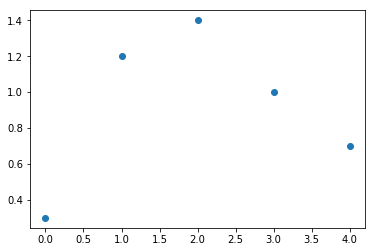

In [37]:
plt.plot(f, g, 'o')

In [38]:
# Create regression matrix describing the mapping according to a degree-5 polynomial
A = np.vander(f, increasing=True)
print(A)

[[   1.    0.    0.    0.    0.]
 [   1.    1.    1.    1.    1.]
 [   1.    2.    4.    8.   16.]
 [   1.    3.    9.   27.   81.]
 [   1.    4.   16.   64.  256.]]


In [39]:
# Compute LU decomposition
lup = scipy.linalg.lu_factor(A)

In [40]:
# Solve!
c = scipy.linalg.lu_solve(lup, g)
print(c)

[ 0.3         1.13333333 -0.125      -0.13333333  0.025     ]


## Let's plot the result

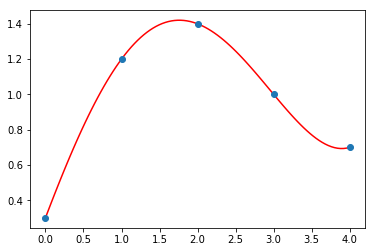

In [41]:
f_fine = np.linspace(0, 4, 100)
A_fine = np.vander(f_fine, N=5, increasing=True)
g_fine = A_fine @ c
plt.plot(f_fine, g_fine, 'r')
plt.plot(f, g, 'o')

## Least squares: regression with lots of noisy data.

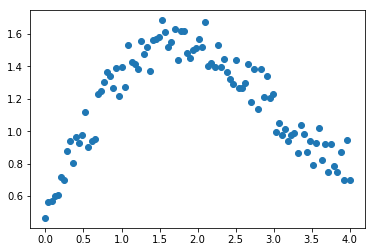

In [42]:
g_noisy = g_fine + np.random.rand(100)*0.3
plt.plot(f_fine, g_noisy, 'o')

In [43]:
A = np.vander(f_fine, increasing=True, N=5)
A.shape

(100, 5)

In [44]:
f_fine = np.linspace(0, 4, 100)
A_fine = np.vander(f_fine, N=A.shape[1], increasing=True)

lup = scipy.linalg.lu_factor(A.T @ A)
c = scipy.linalg.lu_solve(lup, A.T @ g_noisy)

## Let's plot the result

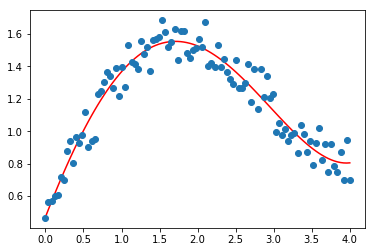

In [45]:
def plot(coeffs):
    A_fine = np.vander(f_fine, N=coeffs.shape[0], increasing=True)
    g_fine = A_fine @ coeffs
    plt.plot(f_fine, g_fine, 'r')
    plt.plot(f_fine, g_noisy, 'o')
    
plot(c)

# Optimization with $L_p$ norm for $p \ne 2$: no need to study this (yet!)

In [46]:
@interact(x=True, p=(2.0, 100.0))
def optimize(p):
    def f(x):
        return numpy.linalg.norm(A_fine @ x - g_noisy, p)
    plot(scipy.optimize.fmin_bfgs(f, np.zeros(5)))
    plt.show()

         Current function value: 1006.425961
         Iterations: 21
         Function evaluations: 929
         Gradient evaluations: 131


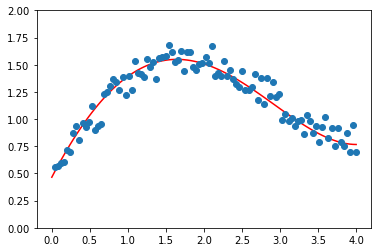

In [47]:
# Stability to outliers
g_noisy[0] = 1000
plt.ylim(0, 2)
optimize(p=1)
g_noisy[0] = 0.4

# Let's try that again with a QR decomposition

(100, 5)
(5, 5)


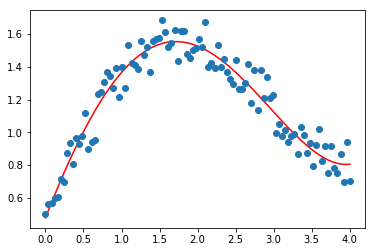

In [48]:
import scipy.linalg as la

g_noisy[0] = 0.5
Q, R = la.qr(A, mode='economic')
print(Q.shape)
print(R.shape)

c2 = la.solve_triangular(R, Q.T @ g_noisy)
plot(c2)

# Tikhonov Regularization

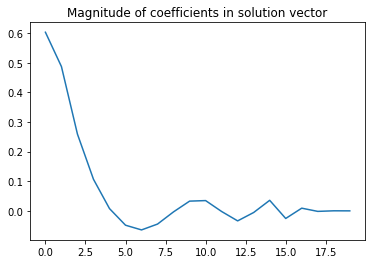

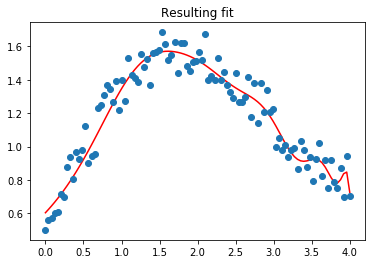

In [59]:
# Polynomial order used
N = 20
# How much regularization? Setting this to zero disables regularization
l = 1

A = np.vander(f_fine, increasing=True, N=N)
At = np.vstack((A, np.eye(N) * l))
gt = np.hstack((g_noisy, np.zeros(N)))
Qt, Rt = la.qr(At, mode='economic')
c3 = la.solve_triangular(Rt, Qt.T @ gt)
plt.plot(c3)
plt.title('Magnitude of coefficients in solution vector')
plt.show()
plot(c3)
plt.title('Resulting fit');